# TensorFlow/Keras Pre-processing

We can easily load the images from Kaggle using TensorFlow's ImageDataGenerator. We then use data augmentation in order to 'improve' the images.

In [45]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    samplewise_center=True,
    samplewise_std_normalization=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    'Training/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'Testing/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


# Setting Up the Model

In [46]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l1(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.4))

# For multi-class classification, we should change the final dense layer to have as 
# many neurons as classes and use a softmax activation function
model.add(Dense(4))  # 4 classes
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy', 'AUC']
)

Halt the training when the model ceases to improve (3 epochs), potentially saving time and computational resources. It can also prevent overfitting by stopping the training before the model begins to memorize the training data at the expense of generalization performance.

In [47]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)

# Training the Model

In [48]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping]
)

Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 13.7001 - accuracy: 0.3136 - auc: 0.5924

# Model Evaluation

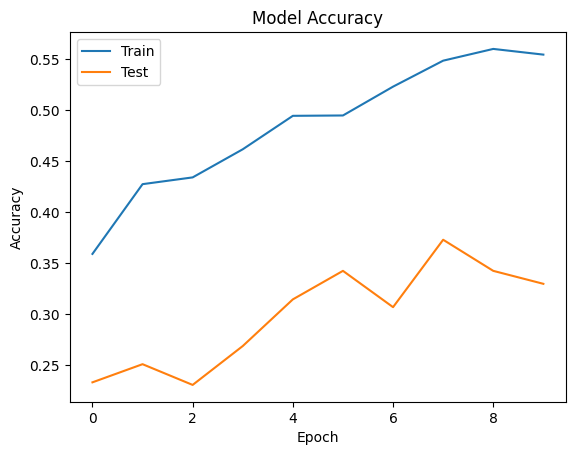

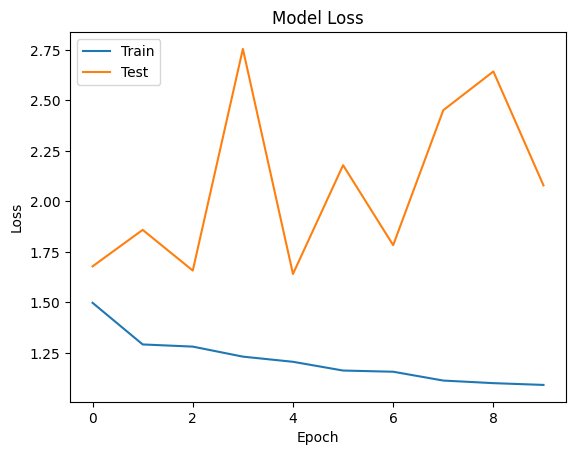

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
